# DELPHI simulations with SPS impedance

To use this notebook:

The first time:
1. Run the two first cells: the results directory is created
2. Inside this directory, create a folder LHC_inj_450GeV_B1_2016
3. Put the Z\*\*\*\_Allthemachine\_\*\*\*.dat which corresponds to this scenario inside the folder

### 1) Import libraries

In [2]:
%pylab notebook

import sys
import commands
from string import *
import time
import numpy as np
from copy import deepcopy
import os,re
from io_lib import *
from tables_lib import select_in_table
from particle_param import *
from Impedance import *
from DELPHI_EVectors import *
import datetime
import inspect
import pickle as pkl
#from LHC_param import *
#from LHC_imp import *
from SPS_param import *

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


### 1bis) Creating the results directory

In [3]:
# machine parameters
machine2save='SPS'; 

# CHANGE DIRECTORY HERE
# subdirectory (inside DELPHI_results/[machine2save]) where to put the results

ResultDir='/afs/cern.ch/work/d/damorim/work/DELPHI_results/SPS/';
os.system("mkdir -p "+ResultDir);

### 2) Parameters

In [11]:
# beam parameters
e,m0,c,E0=proton_param();


# flags for plotting and DELPHI
flagdamperimp=0; # 1 to use frequency dependent damper gain (provided in Zd,fd)
strnorm=[''];
flagnorm=0; # 1 if damper matrix normalized at current chromaticity (instead of at zero chroma)
flagplot=True; # to write impedance files by elements
nevery=1; # downsampling of the impedance (take less points than in the full model)
wake_calc=False; # True -> compute wake as well (otherwise only imp.)


# number of eigenvalues ans convergence criterion for DELPHI
kmax=1; # number of converged eigenvalues (kmax most unstable ones are converged)
kmaxplot=300; # number of kept and plotted eigenvalues (in TMCI plot)
crit=1.0e-4
abseps=1.0e-6


# scan definition
scenarioscan=np.array(['SPS_BB_resonator_Q26_MOSES_injection']) # Q26 with B.Salvant param for MOSES, at injection
print scenarioscan

model=['Q26_MOSES'  for ii in scenarioscan]; # case in SPS_param

Escan=np.array([26e9 for ii in scenarioscan]); # Energy at injection
#Escan=np.array([450e9 for ii in scenarioscan]); # Energy at extraction
subscan=np.arange(0,len(Escan))
print subscan


# setting the scans
planes=['x'];
Qpscan=np.arange(-4,22,2);
dampscan=np.array([0.0,0.01,0.02]); # damper gain scan
Nbscan=np.arange(0,1.02,0.02)*1.0e11;
Mscan=np.array([1]); # scan on number of bunches
imp_fact=1. #impedance factor

queue='2nd'

typelong='Gaussian'
# typelong='uniform'

# initialize impedance model and tune shifts
tuneshiftQp=np.zeros((len(subscan),2,len(Mscan),len(Qpscan),len(dampscan),len(Nbscan),1,1,kmaxplot),dtype=complex);
tuneshiftm0Qp=np.zeros((len(subscan),2,len(Mscan),len(Qpscan),len(dampscan),len(Nbscan),1,1),dtype=complex);
eigenvectors=np.empty((len(subscan),2,len(Mscan),len(Qpscan),len(dampscan),len(Nbscan),1,1),dtype=np.object_)

imp_mod_list=[]; # complete list of impedance scenarios
wake_mod_list=[];# complete list of wake scenarios

['SPS_BB_resonator_Q26_MOSES_injection']
[0]


In [12]:
for iscenario,scenario in enumerate(scenarioscan[subscan]):

    root_result=ResultDir+scenarioscan[subscan[iscenario]]+'/'
    os.system("mkdir -p "+root_result);

In [13]:
machine_str,E,gamma,sigmaz,taub,R,Qx,Qxfrac,Qy,Qyfrac,Qs,eta,f0,omega0,omegas,dphase,Estr=\
SPS_param(E0,E=Escan[subscan[iscenario]],optics=model[subscan[iscenario]])

g,a,b=longdistribution_decomp(taub,typelong=typelong);
avbetax=R/Qx;avbetay=R/Qy; # average beta functions used
print "scenario: ",scenario

print omega0, f0, omegas, Qs, Qx, Qy, eta, taub

scenario:  SPS_BB_resonator_Q26_MOSES_injection
272380.9331 43350.7719068 882.514223243 0.00324 26.185 26.13 0.000617700691968 2.8e-09


In [14]:
simulation_parameters={\
        'Simulation_time':datetime.datetime.now().strftime("%Y-%m-%d %H:%M"),\
        'DELPHI_version':inspect.getmodule(DELPHI_wrapper).__file__,\
        'flagdamperimp':flagdamperimp,\
        'strnorm':strnorm,\
        'flagnorm':flagnorm,\
        'flagplot':flagplot,\
        'nevery':nevery,\
        'wake_calc':wake_calc,\
        'kmax':kmax,\
        'kmaxplot':kmaxplot,\
        'crit':crit,\
        'abseps':abseps,\
        'scenarioscan':scenarioscan,\
        'model':model,\
        'Escan':Escan,\
        'subscan':subscan,\
        'planes':planes,\
        'Qpscan':Qpscan,\
        'dampscan':dampscan,\
        'Nbscan':Nbscan,\
        'Mscan':Mscan,\
        'imp_fact':imp_fact,\
        'queue':queue,\
        'g':g\
        'a':a\
        'b':b\
        'typelong':typelong
        }

### 3) Retrieving the impedance

In [15]:
print 'Loading from impedance database...'+scenario
imp_mod=[]; wake_mod=[];
suffix='_Allthemachine_'+Estr+'_'+scenario+'.dat';

freq_mod,Z_mod=readZ(root_result+"Zxdip"+suffix);
Z_mod*=imp_fact

imp_mod.append(impedance_wake(a=1,b=0,c=0,d=0,plane='x',var=freq_mod,func=Z_mod));

#freq_mod,Z_mod=readZ(root_result+"Zydip"+suffix);
#Z_mod*=imp_fact


#imp_mod.append(impedance_wake(a=0,b=1,c=0,d=0,plane='y',var=freq_mod,func=Z_mod));

imp_mod_list.append(imp_mod);
wake_mod_list.append(wake_mod);

Loading from impedance database...SPS_BB_resonator_Q26_MOSES_injection


### 3bis) Impedance Plot

<IPython.core.display.Javascript object>


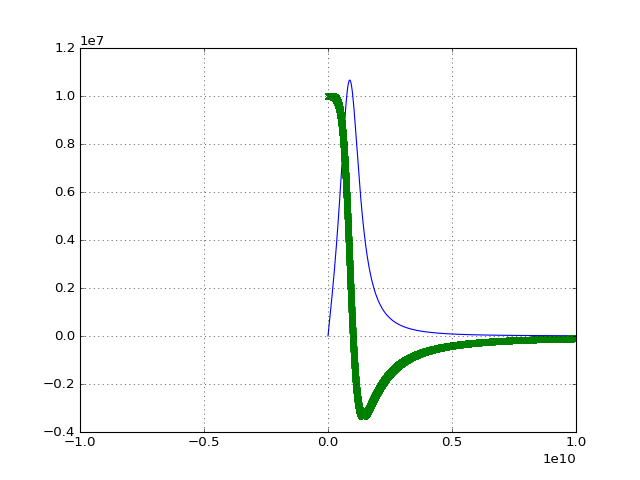

In [16]:
#Puting the impedance inside a list
Zlist_RW_R = deepcopy(imp_mod_list[0][0].func[::nevery,:])
freqlist_RW_R = deepcopy(imp_mod_list[0][0].var[::nevery])

#Impedance plot
plt.close('all')

plt.figure(1)
plt.plot(freqlist_RW_R, Zlist_RW_R[:,0], '-')
plt.plot(freqlist_RW_R, Zlist_RW_R[:,1], 'x')

# plt.plot(-freqlist_RW_R[::-1], -Zlist_RW_R[::-1,0], 'x')
# plt.plot(-freqlist_RW_R[::-1], Zlist_RW_R[::-1,1], 'x')

plt.xlim([-1.0e10,1.0e10])
#plt.ylim([1.0e5,1.0e9])
plt.grid()

plt.show()

### 4) DELPHI calculations

In [17]:
resultsFolder='DELPHI_EVectors_MOSES_Laclare_compare'
root_result=ResultDir+scenario+'/'+resultsFolder+'/';
print root_result

/afs/cern.ch/work/d/damorim/work/DELPHI_results/SPS/SPS_BB_resonator_Q26_MOSES_injection/DELPHI_EVectors_MOSES_Laclare_compare/


In [ ]:
# DELPHI retrieving
for iscenario,scenario in enumerate(scenarioscan[subscan]):

    print 'DELPHI retrieve for '+scenario

    # DELPHI run
    tuneshiftQp[iscenario,:,:,:,:,:,:,:,:],tuneshiftm0Qp[iscenario,:,:,:,:,:,:,:],eigenvectors[iscenario,:,:,:,:,:,:,:]=\
    DELPHI_wrapper(imp_mod_list[iscenario],Mscan,Qpscan,dampscan,Nbscan,[omegas],[dphase],omega0,\
                Qx,Qy,gamma,eta,a,b,taub,g,planes,nevery=nevery,particle='proton',\
                flagnorm=0,flagdamperimp=0,d=None,freqd=None,kmax=kmax,kmaxplot=kmaxplot,crit=crit,abseps=abseps,\
                flagm0=True,lxplusbatch='retrieve',comment=machine_str+scenario+'_'+float_to_str(round(E/1e9))+'GeV_Z'+\
                float_to_str(imp_fact),queue='1nw',dire=root_result+'/',flagQpscan_outside=True);
    
    np.save(root_result+'/Eigenvectors.npy',eigenvectors[iscenario,:,:,:,:,:,:,:])

In [ ]:
''' Output file: data vs Qp '''

for iplane,plane in enumerate(planes):
    for iM,M in enumerate(Mscan):
        for idamp,damp in enumerate(dampscan):
            for Nb in Nbscan:
                strpart=['Re','Im'];
                for ir,r in enumerate(['real','imag']):
                    for iscenario,scenario in enumerate(scenarioscan[subscan]):

                        # output files name for data vs Qp
                        Estr=float_to_str(round(Escan[subscan[iscenario]]/1e9))+'GeV';
                        fileoutdataQp=root_result+'/data_vs_Qp_'+machine_str+'_'+Estr+scenario+'_'+str(M)+'b_d'+float_to_str(damp)+'_Nb'+float_to_str(Nb/1.e11)+'e11_'+str(kmax)+'converged'+strnorm[flagnorm]+'_'+plane;
                        fileoutdataQpm0=root_result+'/data_vs_Qp_m0_'+machine_str+'_'+Estr+scenario+'_'+str(M)+'b_d'+float_to_str(damp)+'_Nb'+float_to_str(Nb/1.e11)+'e11_'+str(kmax)+'converged'+strnorm[flagnorm]+'_'+plane;
                        fileoutdata_all=root_result+'/data_vs_Qp_all_'+machine_str+'_'+Estr+scenario+'_'+str(M)+'b_d'+float_to_str(damp)+'_Nb'+float_to_str(Nb/1.e11)+'e11_'+str(kmax)+'converged'+strnorm[flagnorm]+'_'+plane;

                        ts=getattr(tuneshiftQp[iscenario,iplane,iM,:,idamp,np.where(Nbscan==Nb),0,0,0],r);
                        data=np.hstack((Qpscan.reshape((-1,1)),ts.reshape((-1,1))));
                        write_ncol_file(fileoutdataQp+'_'+r+'.dat',data,header="Qp\t"+strpart[ir]+"_tuneshift")

                        tsm0=getattr(tuneshiftm0Qp[iscenario,iplane,iM,:,idamp,np.where(Nbscan==Nb),0,0],r);
                        data=np.hstack((Qpscan.reshape((-1,1)),ts.reshape((-1,1))));
                        write_ncol_file(fileoutdataQpm0+'_'+r+'.dat',data,header="Qp\t"+strpart[ir]+"_tuneshiftm0")

                        all_unstable_modes=getattr(tuneshiftQp[iscenario,iplane,iM,:,idamp,np.where(Nbscan==Nb),0,0,:],r);
                        data=np.hstack((Qpscan.reshape((-1,1)),all_unstable_modes.reshape((-1,kmaxplot))));
                        write_ncol_file(fileoutdata_all+'_'+r+'.dat',data,header="Qp\t"+strpart[ir]+"_tuneshift")



In [ ]:
tuneshiftQp.shape

In [ ]:
plt.close('all')

fig, (ax1,ax2) = plt.subplots(2, figsize=(800/100,1000/100),dpi=100, sharex=True)

for iNb, Nb in enumerate(Nbscan):
    ax1.plot(Nb*np.ones(len(tuneshiftQp[0,0,0,0,0,iNb,0,0,:])),np.real(tuneshiftQp[0,0,0,0,0,iNb,0,0,:])*omega0/omegas, 'b.')
    ax2.plot(Nb*np.ones(len(tuneshiftQp[0,0,0,0,0,iNb,0,0,:])),np.imag(tuneshiftQp[0,0,0,0,0,iNb,0,0,:]), 'b.')

ax1.set_ylim(-4,1)
ax1.set_xlabel('Intensity')

# plt.savefig('./PyHEADTAIL/DELPHI_SPS_Q20_modes.png',format='png')
plt.show()